In [1]:
!git clone https://github.com/11kartheek/ERA-v2.git

Cloning into 'ERA-v2'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 88 (delta 38), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (88/88), 117.80 KiB | 849.00 KiB/s, done.


In [2]:
%cd ERA-v2/s10

/kaggle/working/ERA-v2/s10


In [3]:
%ls

README.md  S10.ipynb  models.py  utils.py


In [4]:
!pip install torchsummary

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy
from models import Net
from utils import train_transforms,test_transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 34669565.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=False) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.cross_entropy(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
from torch.optim.lr_scheduler import StepLR
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  Net().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import OneCycleLR

LRMIN = 0.001
LRMAX = 0.108
total_epochs = 24
max_at_epoch = 5

# One Cycle Policy scheduler
scheduler = OneCycleLR(optimizer, max_lr=LRMAX, epochs=total_epochs,
                       steps_per_epoch=len(train_loader), pct_start=max_at_epoch/total_epochs, anneal_strategy='linear',
                       div_factor=LRMAX/LRMIN, final_div_factor=LRMAX/LRMIN)

EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion)
#     scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.2648178339004517 Batch_id=97 Accuracy=44.67: 100%|██████████| 98/98 [00:13<00:00,  7.26it/s]



Test set: Average loss: 1.3149, Accuracy: 5280/10000 (52.80%)

EPOCH: 1


Loss=0.8639945983886719 Batch_id=97 Accuracy=63.88: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]



Test set: Average loss: 0.8925, Accuracy: 6846/10000 (68.46%)

EPOCH: 2


Loss=0.6336390376091003 Batch_id=97 Accuracy=73.16: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]



Test set: Average loss: 0.7013, Accuracy: 7538/10000 (75.38%)

EPOCH: 3


Loss=0.6400073170661926 Batch_id=97 Accuracy=78.57: 100%|██████████| 98/98 [00:14<00:00,  6.91it/s]



Test set: Average loss: 0.6018, Accuracy: 7933/10000 (79.33%)

EPOCH: 4


Loss=0.5491932034492493 Batch_id=97 Accuracy=82.28: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s] 



Test set: Average loss: 0.5217, Accuracy: 8218/10000 (82.18%)

EPOCH: 5


Loss=0.5176427364349365 Batch_id=97 Accuracy=84.40: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s] 



Test set: Average loss: 0.5627, Accuracy: 8109/10000 (81.09%)

EPOCH: 6


Loss=0.4004097878932953 Batch_id=97 Accuracy=85.77: 100%|██████████| 98/98 [00:13<00:00,  7.26it/s] 



Test set: Average loss: 0.4425, Accuracy: 8517/10000 (85.17%)

EPOCH: 7


Loss=0.41152241826057434 Batch_id=97 Accuracy=87.12: 100%|██████████| 98/98 [00:14<00:00,  7.00it/s]



Test set: Average loss: 0.4364, Accuracy: 8523/10000 (85.23%)

EPOCH: 8


Loss=0.3842390179634094 Batch_id=97 Accuracy=88.28: 100%|██████████| 98/98 [00:13<00:00,  7.13it/s] 



Test set: Average loss: 0.4144, Accuracy: 8599/10000 (85.99%)

EPOCH: 9


Loss=0.23403504490852356 Batch_id=97 Accuracy=89.44: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s]



Test set: Average loss: 0.4043, Accuracy: 8682/10000 (86.82%)

EPOCH: 10


Loss=0.3523406386375427 Batch_id=97 Accuracy=90.25: 100%|██████████| 98/98 [00:13<00:00,  7.16it/s] 



Test set: Average loss: 0.4055, Accuracy: 8676/10000 (86.76%)

EPOCH: 11


Loss=0.3045547902584076 Batch_id=97 Accuracy=90.97: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s] 



Test set: Average loss: 0.3377, Accuracy: 8869/10000 (88.69%)

EPOCH: 12


Loss=0.17664606869220734 Batch_id=97 Accuracy=91.93: 100%|██████████| 98/98 [00:13<00:00,  7.10it/s]



Test set: Average loss: 0.3845, Accuracy: 8771/10000 (87.71%)

EPOCH: 13


Loss=0.25764307379722595 Batch_id=97 Accuracy=92.29: 100%|██████████| 98/98 [00:13<00:00,  7.19it/s]



Test set: Average loss: 0.3299, Accuracy: 8935/10000 (89.35%)

EPOCH: 14


Loss=0.16620776057243347 Batch_id=97 Accuracy=93.13: 100%|██████████| 98/98 [00:13<00:00,  7.01it/s]



Test set: Average loss: 0.3497, Accuracy: 8893/10000 (88.93%)

EPOCH: 15


Loss=0.24328747391700745 Batch_id=97 Accuracy=93.48: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]



Test set: Average loss: 0.3728, Accuracy: 8835/10000 (88.35%)

EPOCH: 16


Loss=0.20591340959072113 Batch_id=97 Accuracy=93.80: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 0.3457, Accuracy: 8904/10000 (89.04%)

EPOCH: 17


Loss=0.17729662358760834 Batch_id=97 Accuracy=93.87: 100%|██████████| 98/98 [00:13<00:00,  7.09it/s]



Test set: Average loss: 0.3169, Accuracy: 9017/10000 (90.17%)

EPOCH: 18


Loss=0.1934189796447754 Batch_id=97 Accuracy=94.73: 100%|██████████| 98/98 [00:13<00:00,  7.03it/s] 



Test set: Average loss: 0.3181, Accuracy: 9012/10000 (90.12%)

EPOCH: 19


Loss=0.1729167252779007 Batch_id=97 Accuracy=94.99: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s] 



Test set: Average loss: 0.3141, Accuracy: 9038/10000 (90.38%)

EPOCH: 20


Loss=0.11287875473499298 Batch_id=97 Accuracy=94.94: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]



Test set: Average loss: 0.3437, Accuracy: 8984/10000 (89.84%)

EPOCH: 21


Loss=0.13671204447746277 Batch_id=97 Accuracy=95.45: 100%|██████████| 98/98 [00:14<00:00,  6.96it/s]



Test set: Average loss: 0.3143, Accuracy: 9074/10000 (90.74%)

EPOCH: 22


Loss=0.11185808479785919 Batch_id=97 Accuracy=96.06: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 0.3033, Accuracy: 9063/10000 (90.63%)

EPOCH: 23


Loss=0.06625194847583771 Batch_id=97 Accuracy=96.00: 100%|██████████| 98/98 [00:13<00:00,  7.23it/s]



Test set: Average loss: 0.3036, Accuracy: 9099/10000 (90.99%)



In [12]:
!pip install torch-lr-finder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.08E-01


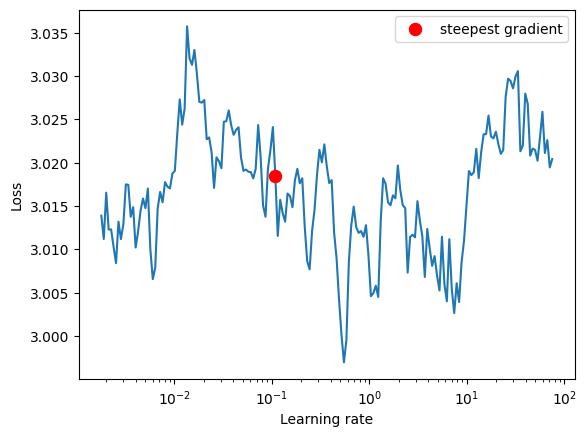

In [13]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
model =  Net().to(device)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [ ]:
lr_finder.history